## 5.2 線形回帰のベイズ推論

In [1]:
# ライブラリのimport

# NumPy用ライブラリ
import numpy as np
# Matplotlib中のpyplotライブラリのインポート
import matplotlib.pyplot as plt
# matplotlib日本語化対応ライブラリのインポート
import japanize_matplotlib
# pandas用ライブラリ
import pandas as pd
# データフレーム表示用関数
from IPython.display import display
# seaborn
import seaborn as sns
# 表示オプション調整
# NumPy表示形式の設定
np.set_printoptions(precision=3, floatmode='fixed')
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# サイズ設定
plt.rcParams['figure.figsize'] = (6, 6)
# 方眼表示ON
plt.rcParams['axes.grid'] = True
# データフレームでの表示精度
pd.options.display.float_format = '{:.3f}'.format
# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)

In [2]:
import pymc as pm
import arviz as az

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on ArViz v{az.__version__}")

import bambi as bmb
print(f"Running on ArViz v{bmb.__version__}")


Running on PyMC v5.16.2
Running on ArViz v0.19.0
Running on ArViz v0.14.0


###  5.2.1 問題設定
アイリスデータセットで花の種類を特定した場合、２つの項目値には正の相関があり。線形回帰(単回帰)に従うと見なせる。  
当実習では、上の点を前提とした上で、最適な回帰式をベイズ推論で求める。  


### 5.2.2 データ準備

#### データ読み込みと確認

In [3]:
# アイリスデータセットの読み込み
df = sns.load_dataset('iris')

# 先頭5行の確認
display(df.head())

#  speciesの分布確認
df['species'].value_counts()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.100,3.500,1.400,0.200,setosa
1,4.900,3.000,1.400,0.200,setosa
2,4.700,3.200,1.300,0.200,setosa
3,4.600,3.100,1.500,0.200,setosa
4,5.000,3.600,1.400,0.200,setosa


species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

#### 分析対象データ抽出

In [4]:
# versicolorの行のみ抽出
df1 = df.query('species == "versicolor"')

# sepal_lengthとsepal_widthの列を抽出
X = df1['sepal_length']
Y = df1['sepal_width']

####  分析対象項目間の散布図表示

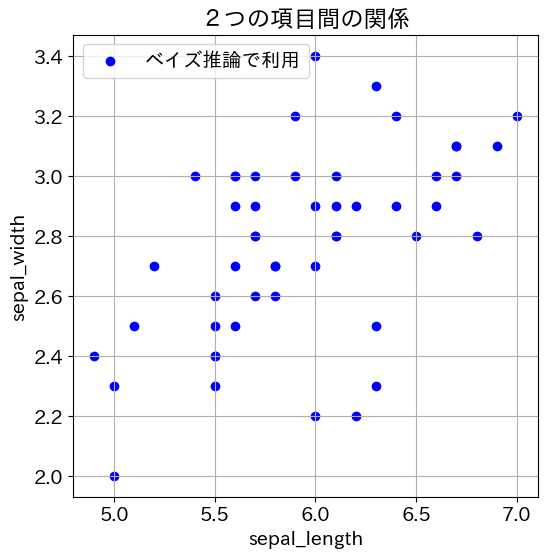

In [5]:
plt.title('２つの項目間の関係')
plt.scatter(X, Y, label='ベイズ推論で利用', c='b', marker='o')
plt.legend()
plt.xlabel('sepal_length')
plt.ylabel('sepal_width');

### 5.2.3 確率モデル定義1

$ y_n =  \alpha  x_n + \beta +  \epsilon_n$

#### 確率モデル定義1
シンプルなモデル定義の方法

In [6]:
# 事前分布
priors = {
    "sepal_length": bmb.Prior("Normal", mu = 0, sigma = 10),# 書籍の α が対応する
    "Intercept": bmb.Prior("Normal", mu = 0, sigma = 10),# 書籍の β が対応する
    "sigma": bmb.Prior("HalfNormal", sigma = 1),# 書籍の ε が対応する
}

model1 = bmb.Model(formula = "sepal_width ~ 1 + sepal_length", data = df1, priors = priors)
model1

       Formula: sepal_width ~ 1 + sepal_length
        Family: gaussian
          Link: mu = identity
  Observations: 50
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 10.0)
            sepal_length ~ Normal(mu: 0.0, sigma: 10.0)
        
        Auxiliary parameters
            sigma ~ HalfNormal(sigma: 1.0)

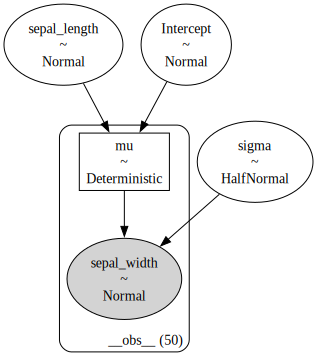

In [7]:
model1.build()
model1.graph()

### 5.2.4 確率モデル定義2
より詳細なモデル定義の方法

#### 確率モデル定義2

In [8]:
# 尤度
likelihood = bmb.Likelihood("Normal", params = ["mu", "sigma"], parent = "mu")
family = bmb.Family("gaussian", likelihood, "identity")

# 事前分布
priors = {
    "sepal_length": bmb.Prior("Normal", mu = 0, sigma = 10),# 係数. 書籍の α が対応する
    "Intercept": bmb.Prior("Normal", mu = 0, sigma = 10),# 切片. 書籍の β が対応する
    "sigma": bmb.Prior("HalfNormal", sigma = 1),# 残差. 書籍の ε が対応する
}

model2 = bmb.Model(formula = "sepal_width ~ 1 + sepal_length", data = df1, family = family, priors = priors)
model2

       Formula: sepal_width ~ 1 + sepal_length
        Family: gaussian
          Link: mu = identity
  Observations: 50
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 10.0)
            sepal_length ~ Normal(mu: 0.0, sigma: 10.0)
        
        Auxiliary parameters
            sigma ~ HalfNormal(sigma: 1.0)

#### 確率モデル構造の可視化

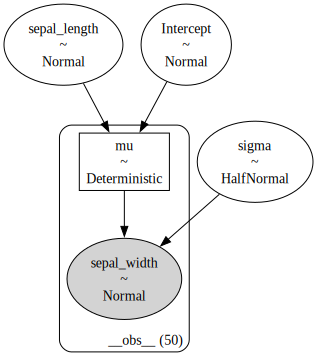

In [9]:
model2.build()
model2.graph()

### 5.2.5 サンプリングと結果分析

#### サンプリング

In [10]:
idata2 = model2.fit(random_seed = 42, nuts_sampler = "nutpie")

c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\pymc\sampling\mcmc.py:303: UserWarning: `var_names` are currently ignored by the nutpie sampler
  warnings.warn(


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,1.01,3
,2000,0,1.01,3
,2000,0,1.01,3
,2000,0,1.07,3


#### plot_trace関数呼び出し

array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

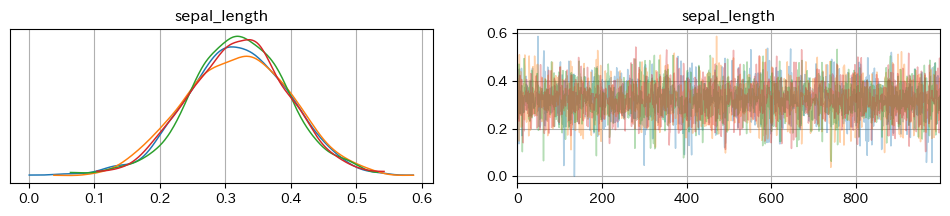

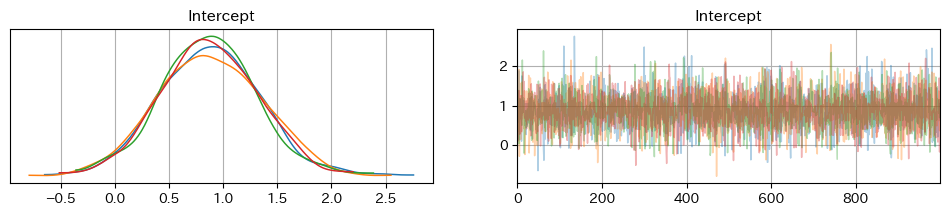

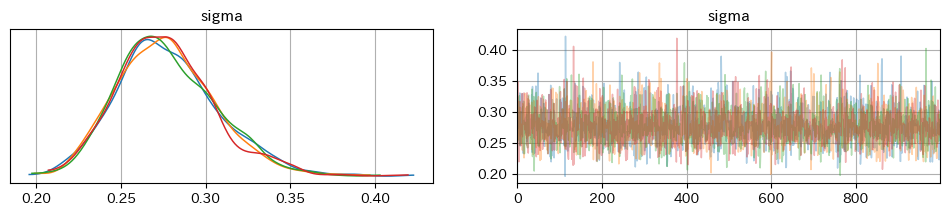

In [11]:
# サンプリングトレースの可視化
az.plot_trace(idata2, compact = False, var_names = ["sepal_length"])
az.plot_trace(idata2, compact = False, var_names = ["Intercept"])
az.plot_trace(idata2, compact = False, var_names = ["sigma"])

#### plot_posterior関数呼び出し

array([<Axes: title={'center': 'sepal_length'}>,
       <Axes: title={'center': 'Intercept'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

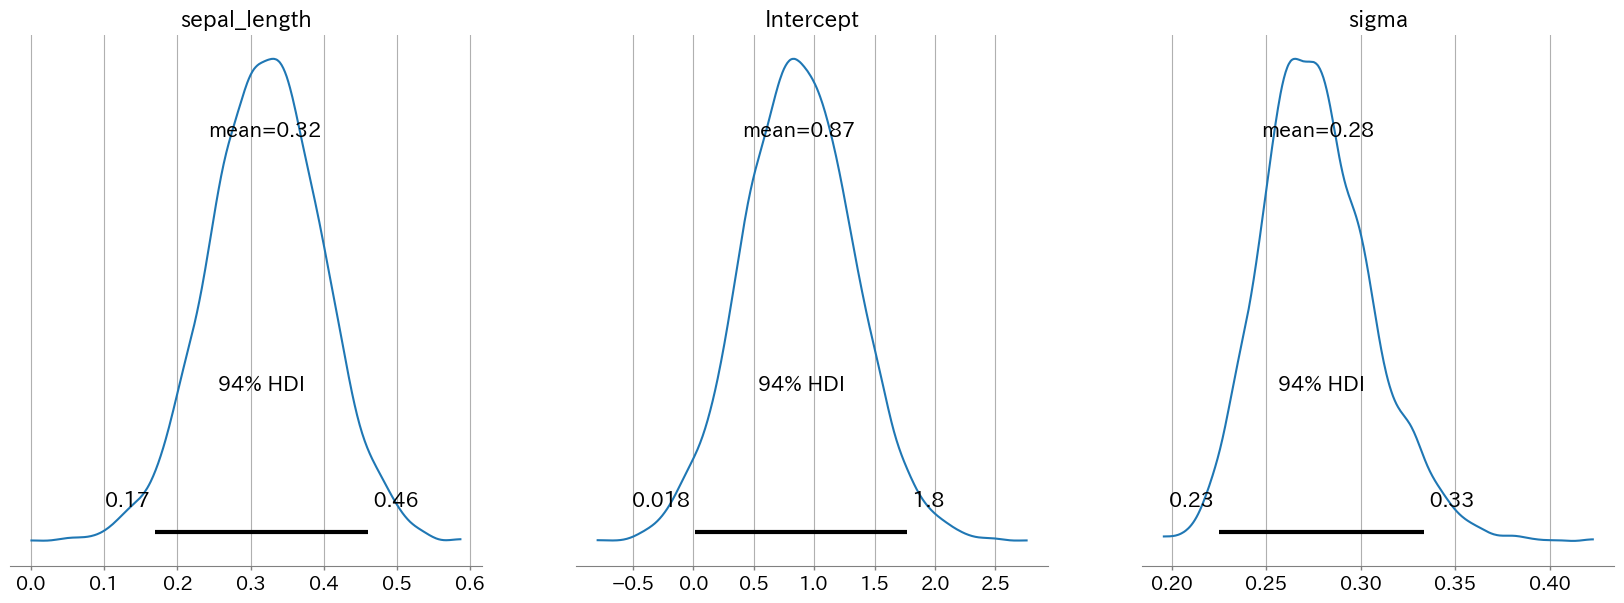

In [12]:
az.plot_posterior(idata2, var_names = ['sepal_length', 'Intercept', 'sigma'])

### 5.2.6 散布図と回帰直線の重ね描き

#### 個別のサンプルにおける回帰直線予測値の計算

In [13]:
# xの２点をNumPy配列にする
x_values = np.array([X.min()-0.1, X.max()+0.1])
print(x_values, x_values.shape)

# サンプリング結果からalphaとbetaを取り出しshapeを加工する
alphas2 = idata2['posterior']['sepal_length'].values.reshape(-1, 1)
betas2 = idata2['posterior']['Intercept'].values.reshape(-1, 1)

# shapeの確認
print(alphas2.shape, betas2.shape)

# 2000パターンそれぞれで、２点の１次関数値の計算
y_preds = x_values * alphas2 + betas2
print(y_preds.shape)

[4.800 7.100] (2,)
(4000, 1) (4000, 1)
(4000, 2)


#### ベイズ推論における回帰直線

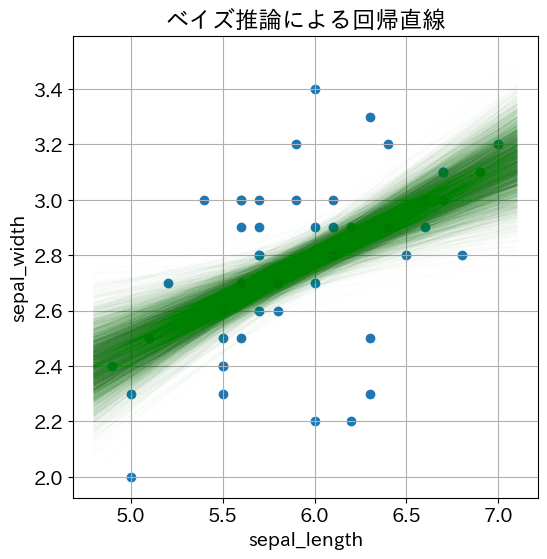

In [14]:
for y_pred in y_preds:
    plt.plot(x_values, y_pred, lw = 1, alpha = 0.01, c = 'g')
plt.scatter(X, Y)
plt.title('ベイズ推論による回帰直線')
plt.xlabel('sepal_length')
plt.ylabel('sepal_width');

###  5.2.7 少ないサンプル数でベイス推論

#### 乱数により3個のインデックスを生成

In [15]:
import random
random.seed(42)
indexes  = range(len(X))
sample_indexes = random.sample(indexes, 3)
print('インデックス値', sample_indexes)

# データ数を3個にする
X_less = X.iloc[sample_indexes]
Y_less = Y.iloc[sample_indexes]
print('xの値', X_less.values)
print('yの値', Y_less.values)

df2 = df1.iloc[sample_indexes, :]
print(df2)

インデックス値 [40, 7, 1]
xの値 [5.500 4.900 6.400]
yの値 [2.600 2.400 3.200]
    sepal_length  sepal_width  petal_length  petal_width     species
90         5.500        2.600         4.400        1.200  versicolor
57         4.900        2.400         3.300        1.000  versicolor
51         6.400        3.200         4.500        1.500  versicolor


#### 抽出した3点の散布図表示

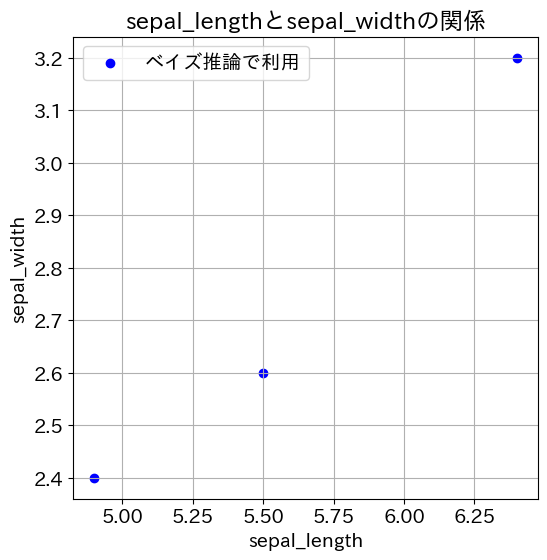

In [16]:
plt.title('sepal_lengthとsepal_widthの関係')
plt.scatter(X_less, Y_less, label='ベイズ推論で利用', c='b', marker='o')
plt.legend()
plt.xlabel('sepal_length')
plt.ylabel('sepal_width');

#### 確率モデル定義とサンプリング

In [17]:
# 事前分布
priors = {
    "sepal_length": bmb.Prior("Normal", mu = 0, sigma = 10),# 書籍の α が対応する
    "Intercept": bmb.Prior("Normal", mu = 0, sigma = 10),# 書籍の β が対応する
    "sigma": bmb.Prior("HalfNormal", sigma = 1),# 書籍の ε が対応する
}

model3 = bmb.Model(formula = "sepal_width ~ 1 + sepal_length", data = df2, priors = priors)
print(model3)

# モデル構造
model1.build()
model1.graph()

# 事後分布生成
idata3 = model3.fit(random_seed = 42, target_accept = 0.995, nuts_sampler = "nutpie")

       Formula: sepal_width ~ 1 + sepal_length
        Family: gaussian
          Link: mu = identity
  Observations: 3
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 10.0)
            sepal_length ~ Normal(mu: 0.0, sigma: 10.0)
        
        Auxiliary parameters
            sigma ~ HalfNormal(sigma: 1.0)


c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\pymc\sampling\mcmc.py:303: UserWarning: `var_names` are currently ignored by the nutpie sampler
  warnings.warn(


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.12,15
,2000,0,0.14,15
,2000,0,0.12,11
,2000,0,0.15,31


#### plot_trace関数でベイズ推論結果の確認

array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

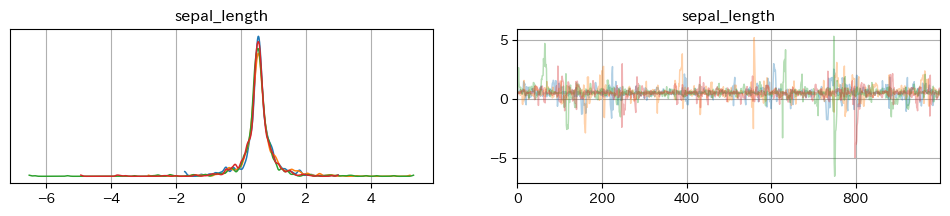

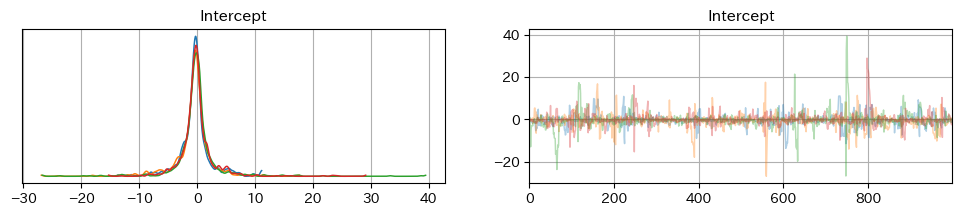

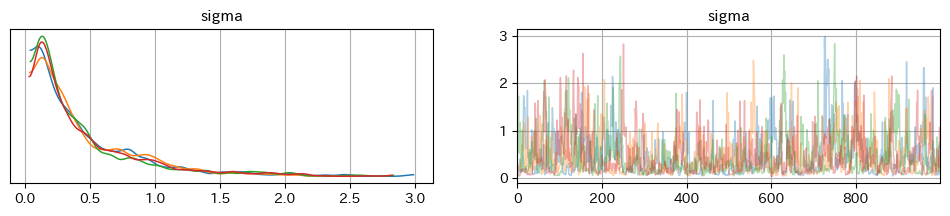

In [18]:
# サンプリングトレースの可視化
az.plot_trace(idata3, compact = False, var_names = ["sepal_length"])
az.plot_trace(idata3, compact = False, var_names = ["Intercept"])
az.plot_trace(idata3, compact = False, var_names = ["sigma"])

#### 散布図と回帰直線の重ね描き

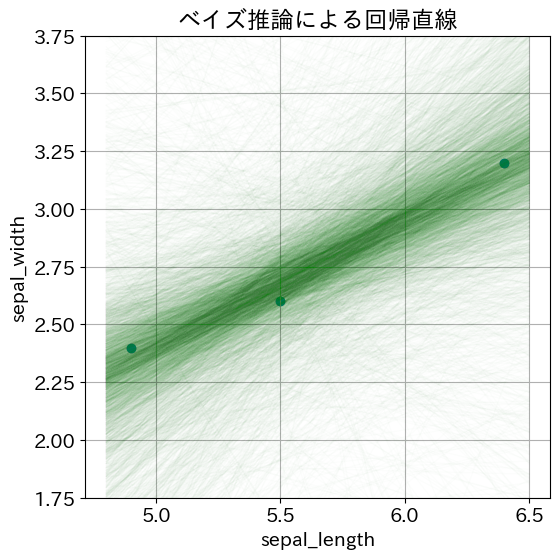

In [19]:
# xの２点をNumPy配列にする
x_values = np.array([X_less.min()-0.1, X_less.max()+0.1])

# サンプル値からalphaとbetaを取り出しshapeを加工する
alphas3 = idata3['posterior']['sepal_length'].values.reshape(-1, 1)
betas3 = idata3['posterior']['Intercept'].values.reshape(-1, 1)

# 2000パターンそれぞれで、２点の１次関数値の計算
y_preds = x_values * alphas3 + betas3

# 2000組の直線を散布図と同時表示
for y_pred in y_preds:
    plt.plot(x_values, y_pred, lw=1, alpha=0.01, c='g')
plt.scatter(X_less, Y_less)
plt.ylim(1.75, 3.75)
plt.title('ベイズ推論による回帰直線')
plt.xlabel('sepal_length')
plt.ylabel('sepal_width');

#### summary関数でベイズ推論結果の確認

In [20]:
summary3 = az.summary(idata3, var_names = ['sepal_length', 'Intercept', 'sigma'])
display(summary3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sepal_length,0.539,0.600,-0.490,1.617,0.020,0.015,1199.000,760.000,1.000
Intercept,-0.288,3.351,-6.401,5.597,0.109,0.087,1260.000,788.000,1.000
sigma,0.448,0.431,0.033,1.258,0.021,0.015,392.000,932.000,1.000


#### バージョンの確認

In [21]:
%load_ext watermark
%watermark --iversions

bambi              : 0.14.0
numpy              : 1.26.4
pandas             : 2.2.2
arviz              : 0.19.0
japanize_matplotlib: 1.1.3
seaborn            : 0.13.2
pymc               : 5.16.2
matplotlib         : 3.9.1

